<a href="https://colab.research.google.com/github/AnshikaaAgarwal/AspireNex_Task2/blob/main/SPAM_SMS_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries






In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df= pd.read_csv('/content/spam.csv',encoding='latin1')

Data Exploration

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.rename(columns={'v1':'target','v2':'message'},inplace=True)
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df['target'] = df['target'].map({'ham': 0, 'spam': 1})

In [11]:
df.head()

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# check for duplicate values
df.duplicated().sum()

403

In [13]:
df = df.drop_duplicates(keep='first')

In [14]:
df.shape

(5169, 2)

In [15]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Importing nltk and removing extra unwanted features from the messages

In [16]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [17]:
nltk.download('punkt')
nltk.download('stopwords')

def transform_text(text):
    ps = PorterStemmer()
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalnum()]
    tokens = [t for t in tokens if t not in stopwords.words('english') and t not in string.punctuation]
    tokens = [ps.stem(t) for t in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
df['message'] = df['message'].apply(transform_text)

Transformed messages

In [19]:
df.head()


,target,message
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


In [20]:
X = df['message']
y = df['target']
print(X)
print(y)

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u pound prize 2 claim e...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: message, Length: 5169, dtype: object
0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: target, Length: 5169, dtype: int64


Spam and non-spam message distribution

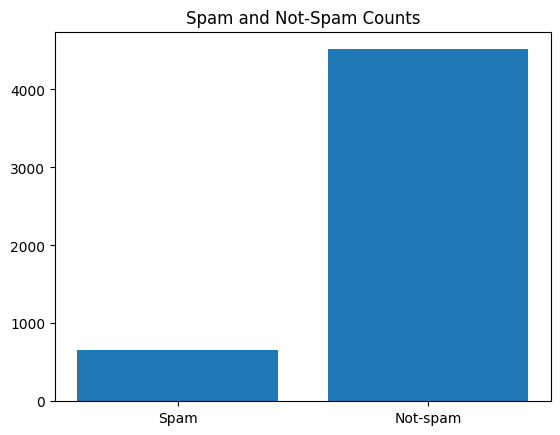

In [21]:
spam_count = (df['target'] == 1).sum()
ham_count = (df['target'] == 0).sum()
labels = ['Spam', 'Not-spam']
values = [spam_count, ham_count]
plt.bar(labels, values)
plt.title('Spam and Not-Spam Counts')
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [23]:
print(X_train.shape)
print(y_train.shape)

(4135,)
(4135,)


employing undersampling technique to balance the data

In [24]:
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled, y_train_resampled = rus.fit_resample(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

In [25]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)
y_train_resampled_counts = pd.Series(y_train_resampled).value_counts()
print(y_train_resampled_counts)


(1058, 1)
(1058,)
0    529
1    529
Name: count, dtype: int64


TF_IDF vectorizer

In [26]:
vectorizer = TfidfVectorizer(max_features=3000)

Performed UnderSampling

In [27]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=6)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train.values.reshape(-1, 1), y_train)

In [28]:
X_train_resampled = X_train_resampled.flatten()

In [29]:
X_train_tfidf = vectorizer.fit_transform(X_train_resampled)
X_test_tfidf = vectorizer.transform(X_test)

Naive Bayes

In [30]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train_resampled)

y_pred_nb = nb.predict(X_test_tfidf)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.9226305609284333
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       910
           1       0.62      0.94      0.74       124

    accuracy                           0.92      1034
   macro avg       0.80      0.93      0.85      1034
weighted avg       0.95      0.92      0.93      1034



Logistic Regression

In [31]:
lr = LogisticRegression(class_weight='balanced',random_state=6)
lr.fit(X_train_tfidf, y_train_resampled)

y_pred_lr = lr.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9564796905222437
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       910
           1       0.77      0.91      0.83       124

    accuracy                           0.96      1034
   macro avg       0.88      0.94      0.90      1034
weighted avg       0.96      0.96      0.96      1034



Support Vector Machine

In [32]:
svm = SVC(class_weight='balanced',random_state=6,kernel='linear', probability=True)
svm.fit(X_train_tfidf, y_train_resampled)

y_pred_svm = svm.predict(X_test_tfidf)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9497098646034816
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       910
           1       0.73      0.91      0.81       124

    accuracy                           0.95      1034
   macro avg       0.86      0.93      0.89      1034
weighted avg       0.96      0.95      0.95      1034



Comparisons

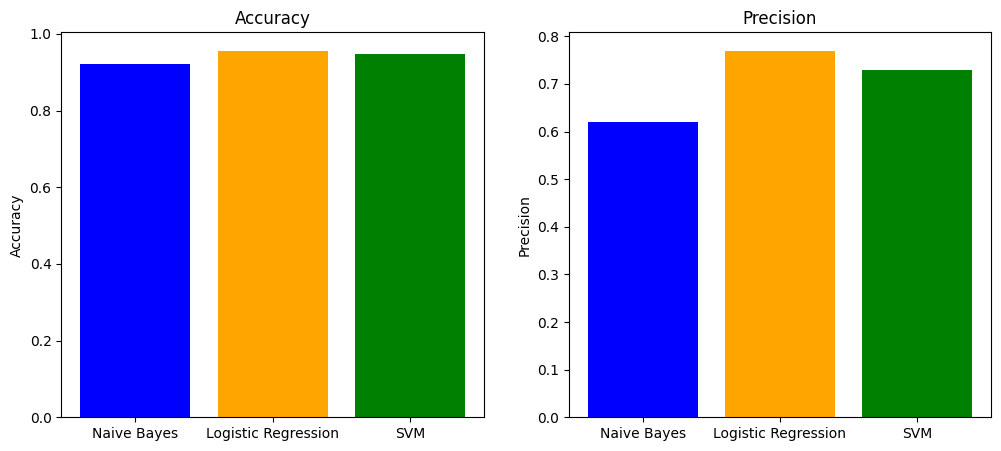

In [35]:
import matplotlib.pyplot as plt

model_names = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracy_values = [0.9216634429400387,0.9564796905222437,0.9487427466150871
]
precision_values = [ 0.62 , 0.77,   0.73 ]
barcolors=['blue', 'orange', 'green']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(model_names, accuracy_values, color=barcolors)
axs[0].set_title('Accuracy')
axs[0].set_ylabel('Accuracy')

axs[1].bar(model_names, precision_values, color=barcolors)
axs[1].set_title('Precision')
axs[1].set_ylabel('Precision')

plt.show()